# <font color='green'>NLP Project</font>

<div class="alert alert-block alert-warning">
<b>
Amirkabir University of Technology<br>
Fall 2022<br>
Course: Machine Learning<br>
Instructor: Dr. Seyedin<br>
<b><font color='green'>Author:</font></b><br>
Name: Reza hendi<br />
Student Number:9723144 </div>


***

In [40]:
!pip install transformers
!pip install datasets
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from transformers import AutoTokenizer
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
import pandas as pd
import torch
import tensorflow as tf
import re
import string
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
from sklearn import metrics
from sentence_transformers import SentenceTransformer
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# <font color='purple'>Loading the dataset from Hugging Face</font>

In [42]:
from datasets import load_dataset
dataset = load_dataset('tweet_eval', 'hate')

  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
print(dataset['train'][0])
print(dataset['test'][2])

{'text': '@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…', 'label': 0}
{'text': '@user @user Those People Invaded Us!!! They DO NOT BELING HERE & HAVE NO RIGHTS! Its #AmericaFIRST! Open Your House To Them If Your That IGNORANT! & Yes Im A #Christian Too! #NODACA!', 'label': 1}


# <font color='purple'>Preprocessing Data</font>


In [44]:
def preprocess_sentence(sentence):
    # remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    # remove whitespace
    sentence = sentence.strip()
    # remove stopwords
    sentence = ' '.join([word for word in sentence.split() if word not in stopwords.words('english')])
    return sentence

In [45]:
def preprocess_dataset(dataset):
    dataset = dataset.map(lambda examples: {'text': preprocess_sentence(examples['text'])})
    return dataset

In [46]:
dataset = preprocess_dataset(dataset)
print(dataset['train'][0])
print(dataset['test'][2])

{'text': 'user nice new signage Are concerned Beatlemania style hysterical crowds crongregating you…', 'label': 0}
{'text': 'user user Those People Invaded Us They DO NOT BELING HERE HAVE NO RIGHTS Its AmericaFIRST Open Your House To Them If Your That IGNORANT Yes Im A Christian Too NODACA', 'label': 1}


In [47]:
from sklearn.model_selection import train_test_split
data=dataset['train']['text']
labels=dataset['train']['label']
X_train, X_val, y_train, y_val = train_test_split(data,labels, test_size=0.2,stratify=labels)

In [48]:

Albert_tokenizer = AlbertTokenizer.from_pretrained("vumichien/albert-base-v2-imdb")

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

In [49]:
def convert_example_to_feature(review):
  return Albert_tokenizer.encode_plus(review, 
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [50]:
batch_size = 8
# train dataset
ds_train = zip(data,labels)
ds_test = zip(X_val, y_val)
ds_train_encoded = encode_examples(ds_train).shuffle(len(data)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

# <font color='purple'>Fine-tune a model</font>

In [51]:
from transformers import TFAlbertForSequenceClassification

Albert_model = TFAlbertForSequenceClassification.from_pretrained("vumichien/albert-base-v2-imdb")
Albert_model.trainable = True

Albert_model.summary()

Some layers from the model checkpoint at vumichien/albert-base-v2-imdb were not used when initializing TFAlbertForSequenceClassification: ['dropout_857']
- This IS expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertForSequenceClassification were initialized from the model checkpoint at vumichien/albert-base-v2-imdb.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForSequenceClassification for predictions without further training.


Model: "tf_albert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 albert (TFAlbertMainLayer)  multiple                  11683584  
                                                                 
 dropout_24 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 11,685,122
Trainable params: 11,685,122
Non-trainable params: 0
_________________________________________________________________


In [53]:
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 5

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

Albert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)

In [55]:
# history=bert_model.fit(ds_train_encoded,
#                          batch_size=batch_size,
#                          epochs=number_of_epochs
#                          validation_data=ds_test_encoded)
history=Albert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded)


Epoch 1/5
1125/1125 [==============================] - 1019s 905ms/step - loss: 0.5368 - accuracy: 0.7291 - val_loss: 0.4969 - val_accuracy: 0.7439
Epoch 2/5
1125/1125 [==============================] - 1017s 904ms/step - loss: 0.4617 - accuracy: 0.7737 - val_loss: 0.3914 - val_accuracy: 0.8167
Epoch 3/5
1125/1125 [==============================] - 1017s 904ms/step - loss: 0.4109 - accuracy: 0.8039 - val_loss: 0.3541 - val_accuracy: 0.8383
Epoch 4/5
1125/1125 [==============================] - 1016s 903ms/step - loss: 0.3584 - accuracy: 0.8383 - val_loss: 0.3099 - val_accuracy: 0.8661
Epoch 5/5
1125/1125 [==============================] - 1016s 903ms/step - loss: 0.3089 - accuracy: 0.8674 - val_loss: 0.2049 - val_accuracy: 0.9278


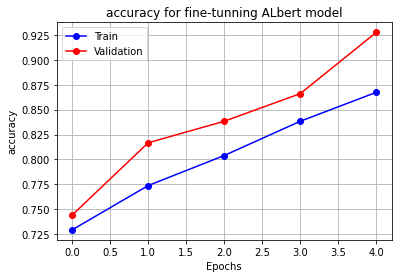

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("accuracy for fine-tunning ALbert model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("ALbert-finetune-loss.png")